In [1]:
## Requires condaScanpy1_4_7.yaml

import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sns
import scvelo as scv
import glob
import os

sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

/wynton/home/ye/codymowery/miniconda3/envs/scanpy_sagarbatch2_umap0.3.10/lib/python3.8/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.7.dev26+gc255fa10 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0


In [2]:
samples = ['WT_ROSI','WT_HFD','KO_ROSI','KO_HFD']
## Set path to cellranger output directories
h5_loc = 'CM_AM_04/'

In [3]:
print(samples)

['WT_ROSI', 'WT_HFD', 'KO_ROSI', 'KO_HFD']


### Loading Files

In [4]:
infile = samples.pop(0)
geno = infile[0:2]
condition = infile[3:]
h5 = h5_loc + infile + '_analysis/outs/filtered_feature_bc_matrix.h5'

bdata = sc.read_10x_h5(h5)
bdata.X = bdata.X.toarray()

bdata.obs['sample'] = [infile]*bdata.n_obs
bdata.obs['geno'] = [geno]*bdata.n_obs
bdata.obs['condition'] = [condition]*bdata.n_obs
bdata.var_names_make_unique()
bdata.obs_names_make_unique()

bdata
print(bdata.obs['sample'].value_counts())
print(samples)

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_04/WT_ROSI_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


WT_ROSI    3572
Name: sample, dtype: int64
['WT_HFD', 'KO_ROSI', 'KO_HFD']


In [5]:
## Preserve bdata to avoid having to run above cell every time
adata = bdata

## Loop through samples
for i in range(len(samples)):
    infile = samples[i]
    geno = infile[0:2]
    condition = infile[3:]
    h5 = h5_loc + infile + '_analysis/outs/filtered_feature_bc_matrix.h5'

    bdata_tmp = sc.read_10x_h5(h5)
    bdata_tmp.X = bdata_tmp.X.toarray()

    bdata_tmp.obs['sample'] = [infile]*bdata_tmp.n_obs
    bdata_tmp.obs['geno'] = [geno]*bdata_tmp.n_obs
    bdata_tmp.obs['condition'] = [condition]*bdata_tmp.n_obs
    bdata_tmp.var_names_make_unique()
    bdata_tmp.obs_names_make_unique()

    print(bdata_tmp.obs['sample'].value_counts())
    bdata_tmp
    
    ## Concatenate to main bdata object
    adata = adata.concatenate(bdata_tmp)
    #adata.var['gene_ids'] = adata.var['gene_ids-1']
    #adata.var.drop(columns = ['gene_ids-1', 'gene_ids-0'], inplace=True)
    adata.obs_names = [c.split("-")[0] for c in adata.obs_names]
    adata.obs_names_make_unique(join='_')

reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_04/WT_HFD_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:01)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


WT_HFD    5508
Name: sample, dtype: int64
reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_04/KO_ROSI_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


KO_ROSI    3682
Name: sample, dtype: int64
reading /wynton/group/ye/cody/marsonlab/sagar/data/CM_AM_04/KO_HFD_analysis/outs/filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


KO_HFD    3105
Name: sample, dtype: int64


In [6]:
print(adata.obs['sample'].value_counts())
print('')
print(adata.obs['geno'].value_counts())
print('')
print(adata.obs['condition'].value_counts())
print('')
adata

WT_HFD     5508
KO_ROSI    3682
WT_ROSI    3572
KO_HFD     3105
Name: sample, dtype: int64

WT    9080
KO    6787
Name: geno, dtype: int64

HFD     8613
ROSI    7254
Name: condition, dtype: int64



AnnData object with n_obs × n_vars = 15867 × 31053 
    obs: 'batch', 'condition', 'geno', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'

## Processing Data

filtered out 38 cells that have less than 200 genes expressed
filtered out 14000 genes that are detected in less than 3 cells


... storing 'condition' as categorical
... storing 'geno' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


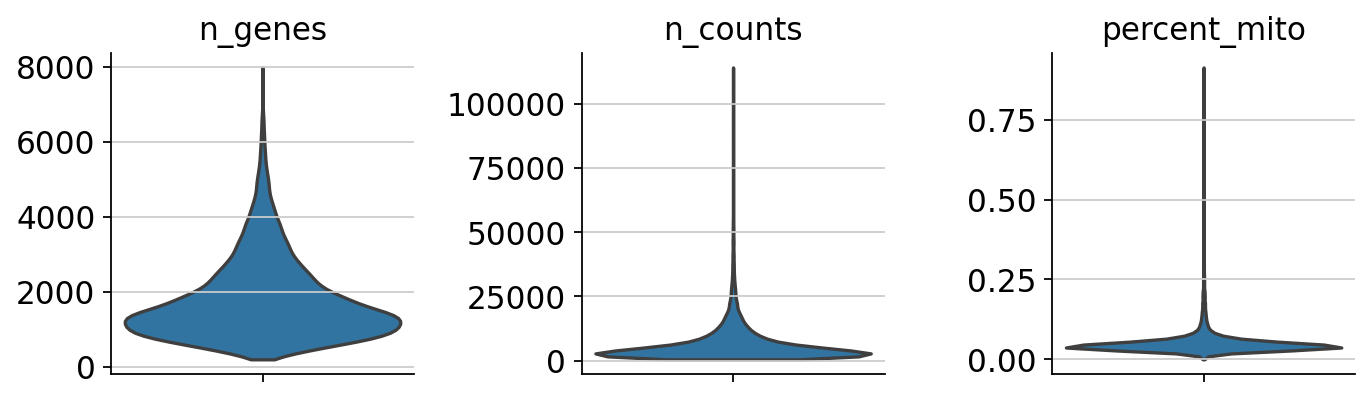

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_cells(adata, min_counts=1)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_genes(adata, min_counts=1)

adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('mt-') for gene in adata.var_names]
adata.obs['percent_mito'] = adata.X[:, mt_gene_mask].sum(1)/adata.obs['n_counts']

sc.pl.violin(adata, keys=['n_genes', 'n_counts', 'percent_mito'], size=0, multi_panel=True)

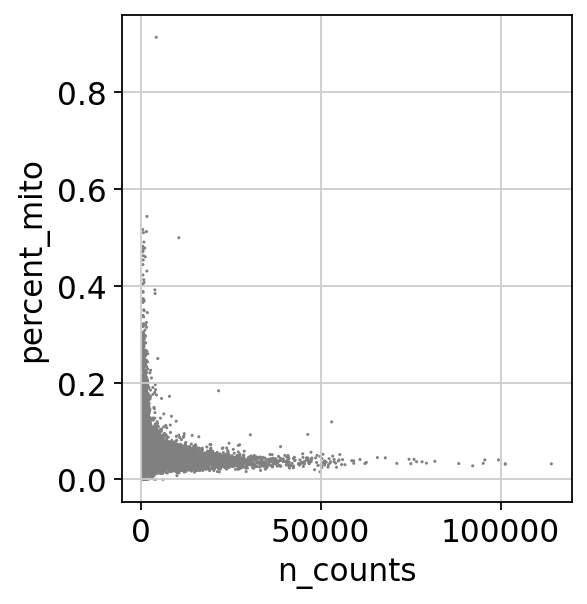

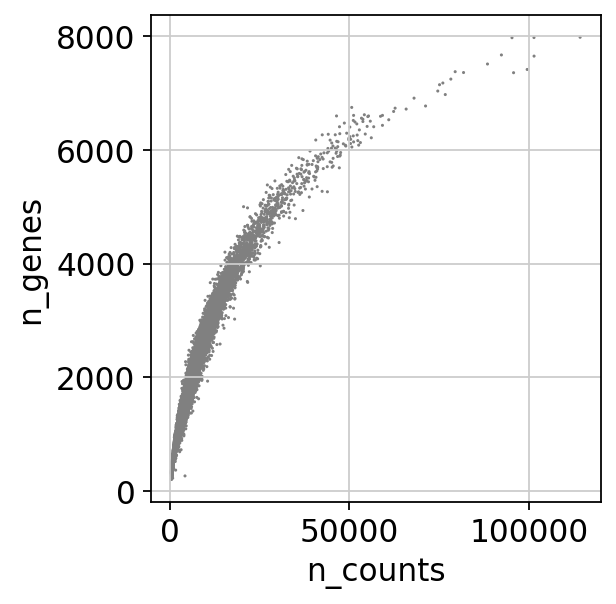

In [8]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [9]:
adata = adata[adata.obs.n_genes < 6000, :]
adata = adata[adata.obs.percent_mito < 0.25, :]

In [10]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:04): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


extracting highly variable genes
    finished (0:00:04)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


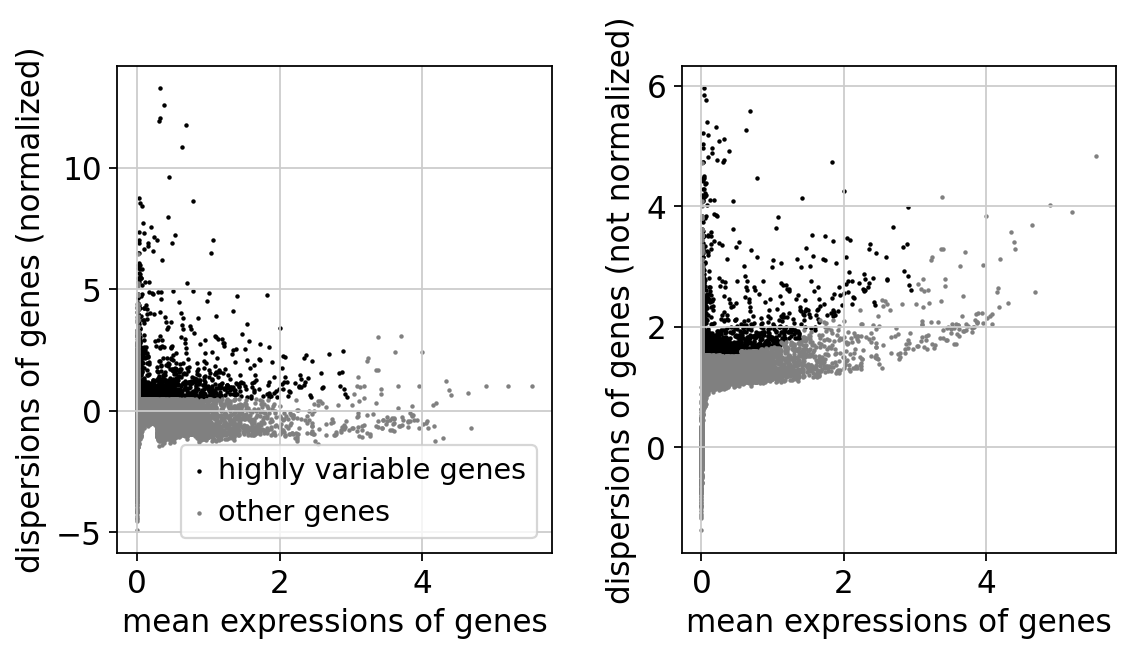

In [11]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [12]:
adata
print('')
print(adata.obs['sample'].value_counts())
print('')
print(adata.obs['geno'].value_counts())
print('')
print(adata.obs['condition'].value_counts())
print('')


WT_HFD     5457
KO_ROSI    3663
WT_ROSI    3480
KO_HFD     3058
Name: sample, dtype: int64

WT    8937
KO    6721
Name: geno, dtype: int64

HFD     8515
ROSI    7143
Name: condition, dtype: int64



In [13]:
print(np.any(adata.X.sum(axis=0) == 0))
print(np.any(adata.X.sum(axis=1) == 0))

True
False


In [14]:
adata = adata[:,adata.X.sum(axis=0) > 0].copy()

In [15]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

regressing out ['n_counts', 'percent_mito']
    finished (0:03:56)


In [16]:
sc.pp.scale(adata, max_value=10)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:05)


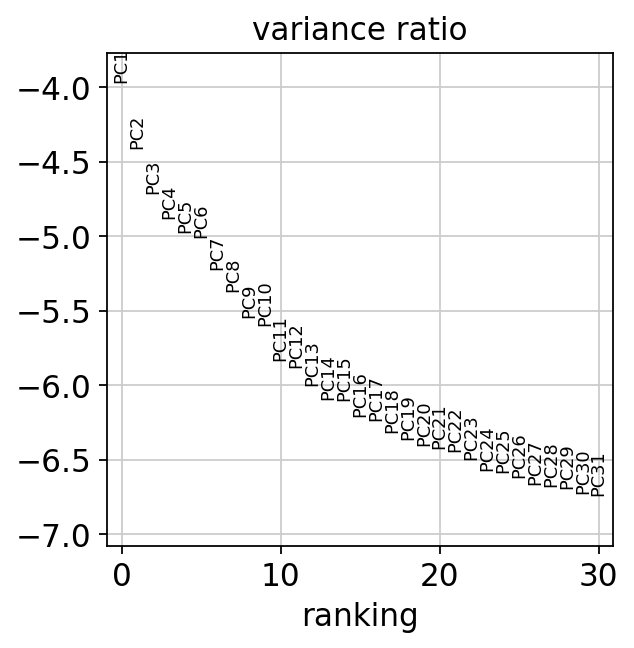

In [17]:
sc.tl.pca(adata, svd_solver='arpack', use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
adata

AnnData object with n_obs × n_vars = 15658 × 17051 
    obs: 'batch', 'condition', 'geno', 'sample', 'n_genes', 'n_counts', 'log_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## Dimensionality Reduction & Clustering

In [19]:
adata

AnnData object with n_obs × n_vars = 15658 × 17051 
    obs: 'batch', 'condition', 'geno', 'sample', 'n_genes', 'n_counts', 'log_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [20]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20, random_state=1)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


In [21]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:14)


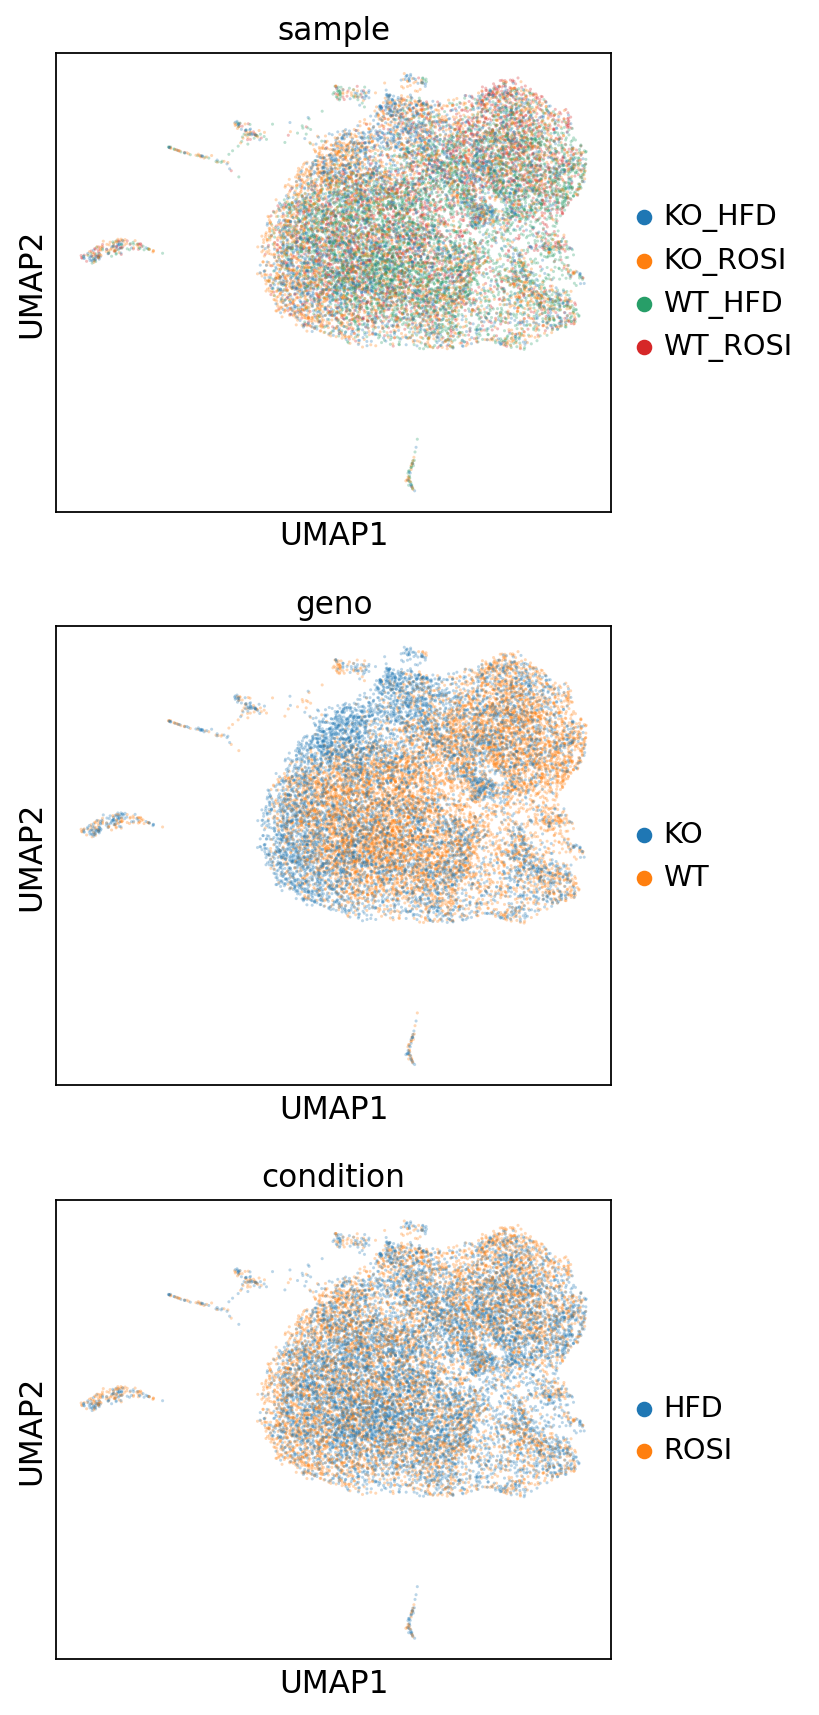

In [22]:
sc.pl.umap(adata, color=['sample','geno','condition'], ncols=1, alpha=0.3)

In [23]:
adata

AnnData object with n_obs × n_vars = 15658 × 17051 
    obs: 'batch', 'condition', 'geno', 'sample', 'n_genes', 'n_counts', 'log_counts', 'percent_mito'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'geno_colors', 'condition_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
sc.tl.leiden(adata, resolution = 0.25)

running Leiden clustering
    finished: found 6 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


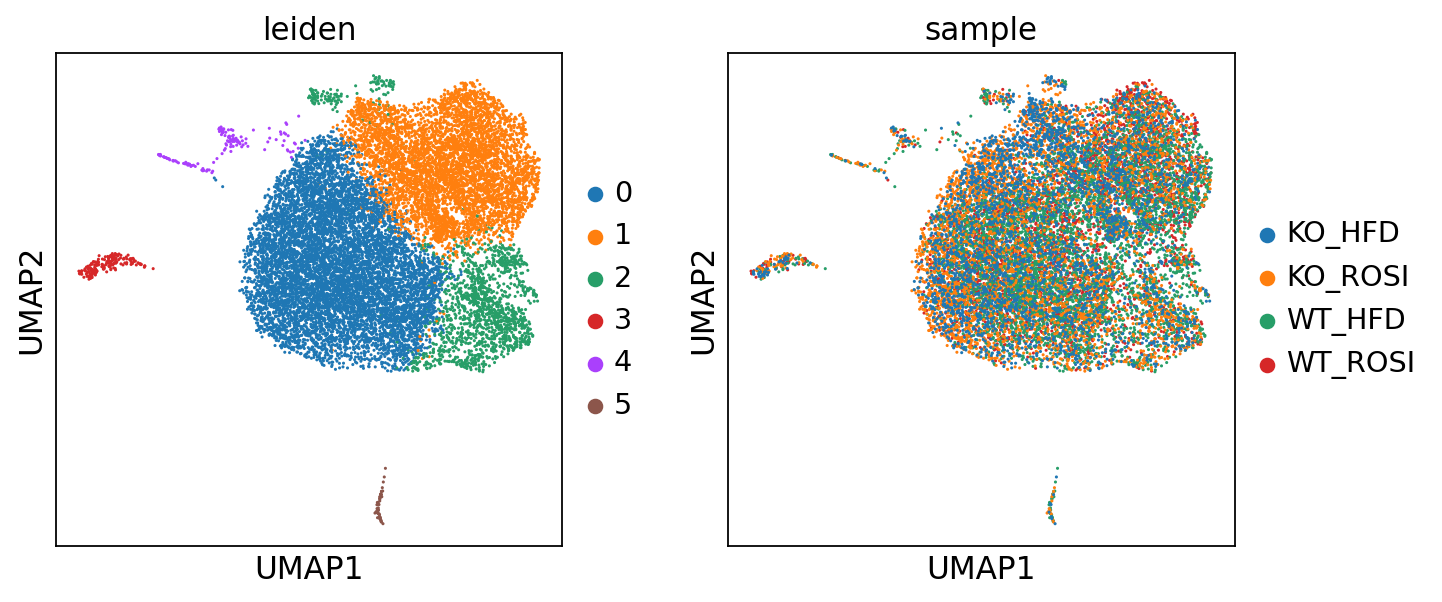

In [25]:
sc.pl.umap(adata, color=['leiden','sample'])

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:35)


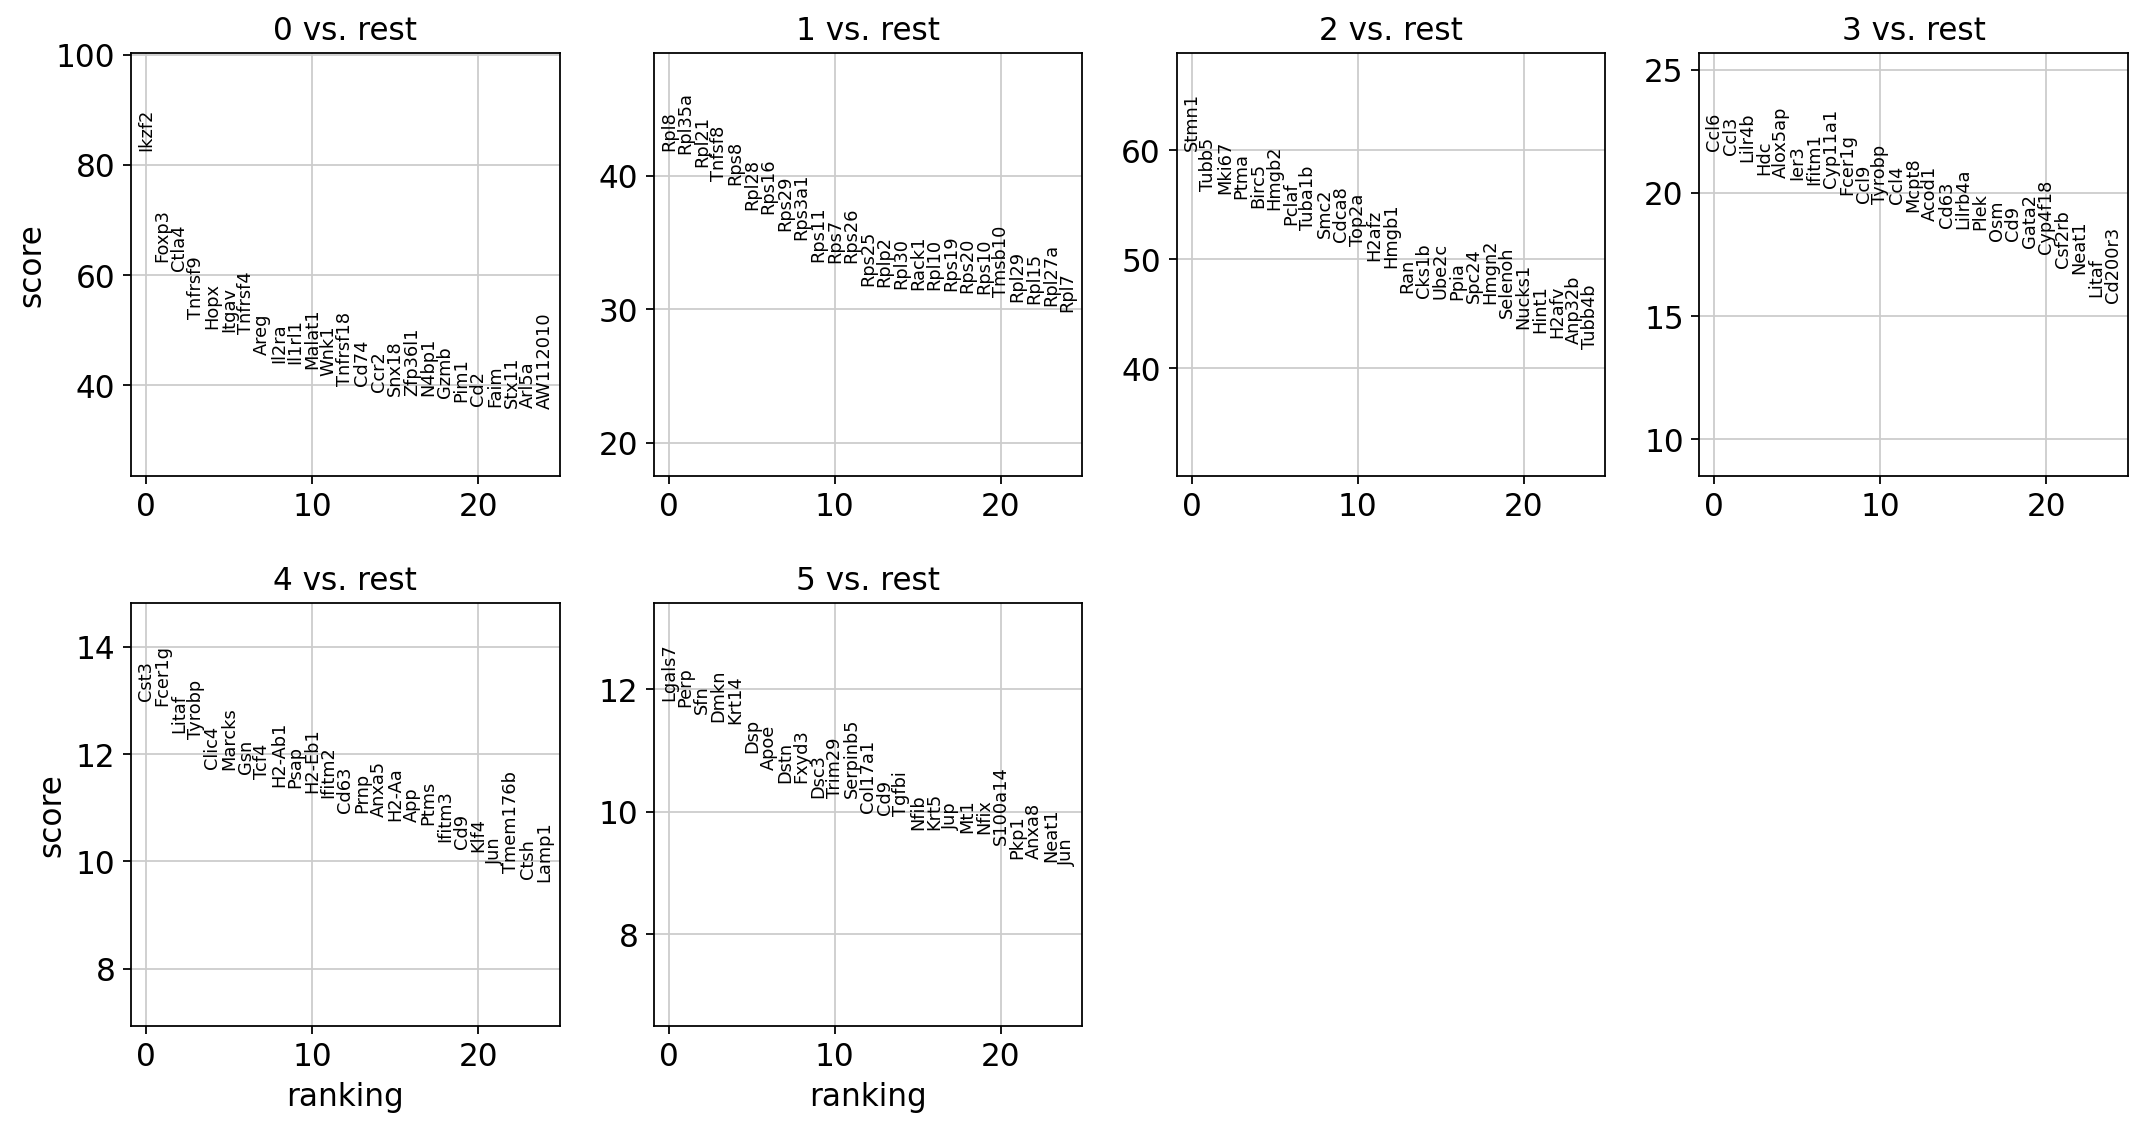

,0,1,2,3,4,5
0,Ikzf2,Rpl8,Stmn1,Ccl6,Cst3,Lgals7
1,Foxp3,Rpl35a,Tubb5,Ccl3,Fcer1g,Perp
2,Ctla4,Rpl21,Mki67,Lilr4b,Litaf,Sfn
3,Tnfrsf9,Tnfsf8,Ptma,Hdc,Tyrobp,Dmkn
4,Hopx,Rps8,Birc5,Alox5ap,Clic4,Krt14
5,Itgav,Rpl28,Hmgb2,Ier3,Marcks,Dsp
6,Tnfrsf4,Rps16,Pclaf,Ifitm1,Gsn,Apoe
7,Areg,Rps29,Tuba1b,Cyp11a1,Tcf4,Dstn
8,Il2ra,Rps3a1,Smc2,Fcer1g,H2-Ab1,Fxyd3
9,Il1rl1,Rps11,Cdca8,Ccl9,Psap,Dsc3


In [26]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

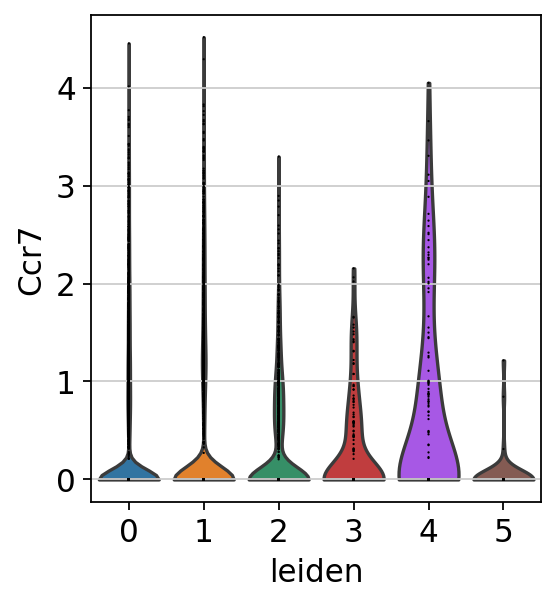

In [27]:
sc.pl.violin(adata, ['Ccr7'], 'leiden', jitter=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:28)


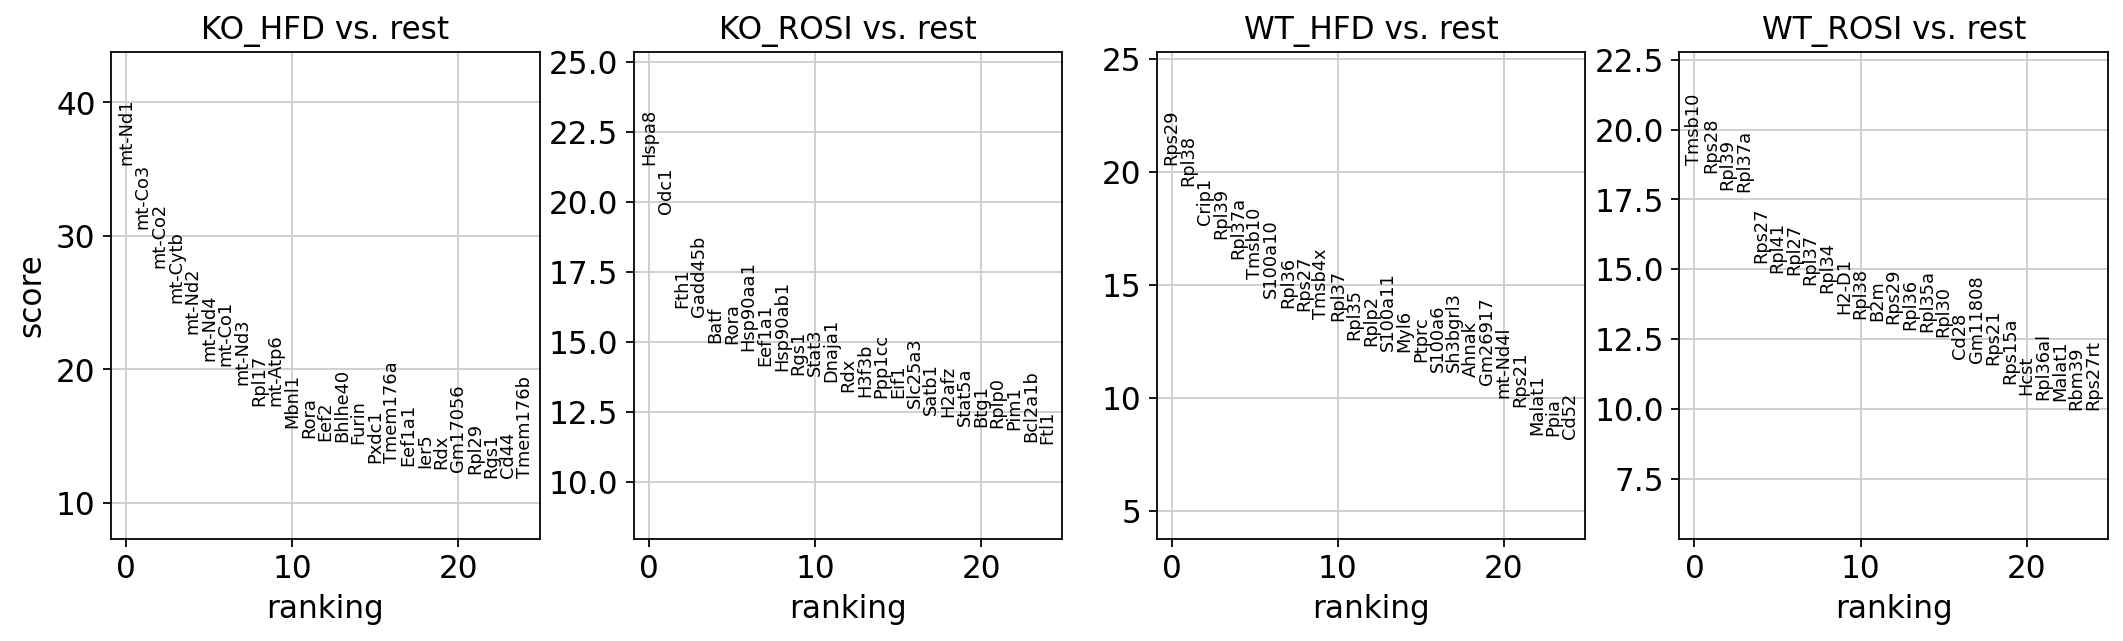

,KO_HFD,KO_ROSI,WT_HFD,WT_ROSI
0,mt-Nd1,Hspa8,Rps29,Tmsb10
1,mt-Co3,Odc1,Rpl38,Rps28
2,mt-Co2,Fth1,Crip1,Rpl39
3,mt-Cytb,Gadd45b,Rpl39,Rpl37a
4,mt-Nd2,Batf,Rpl37a,Rps27
5,mt-Nd4,Rora,Tmsb10,Rpl41
6,mt-Co1,Hsp90aa1,S100a10,Rpl27
7,mt-Nd3,Eef1a1,Rpl36,Rpl37
8,Rpl17,Hsp90ab1,Rps27,Rpl34
9,mt-Atp6,Rgs1,Tmsb4x,H2-D1


In [28]:
sc.tl.rank_genes_groups(adata, 'sample', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

## Remove APCs and recluster Leiden

In [29]:
remove=['3','4','5']
filt = adata[~adata.obs['leiden'].isin(remove)]
sc.tl.leiden(filt, resolution=0.9, key_added='leiden_r0.9')

running Leiden clustering


Trying to set attribute `.obs` of view, copying.


    finished: found 14 clusters and added
    'leiden_r0.9', the cluster labels (adata.obs, categorical) (0:00:52)


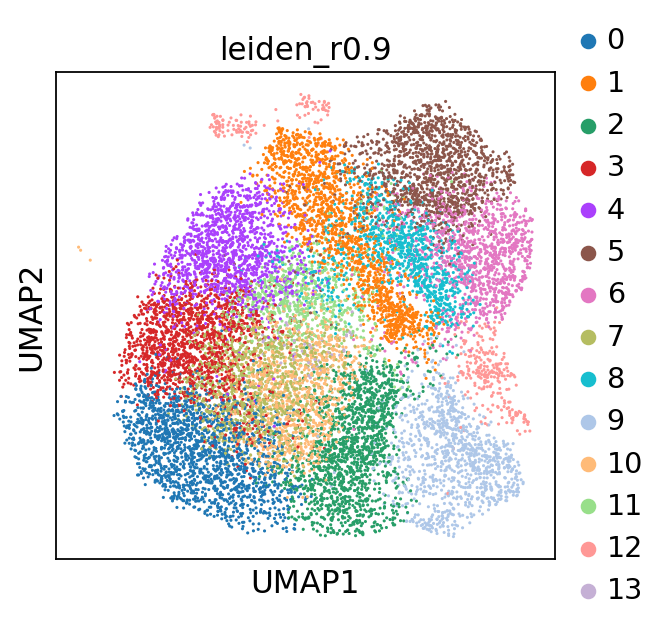

In [30]:
sc.pl.umap(filt, color=['leiden_r0.9'], ncols=1)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:48)


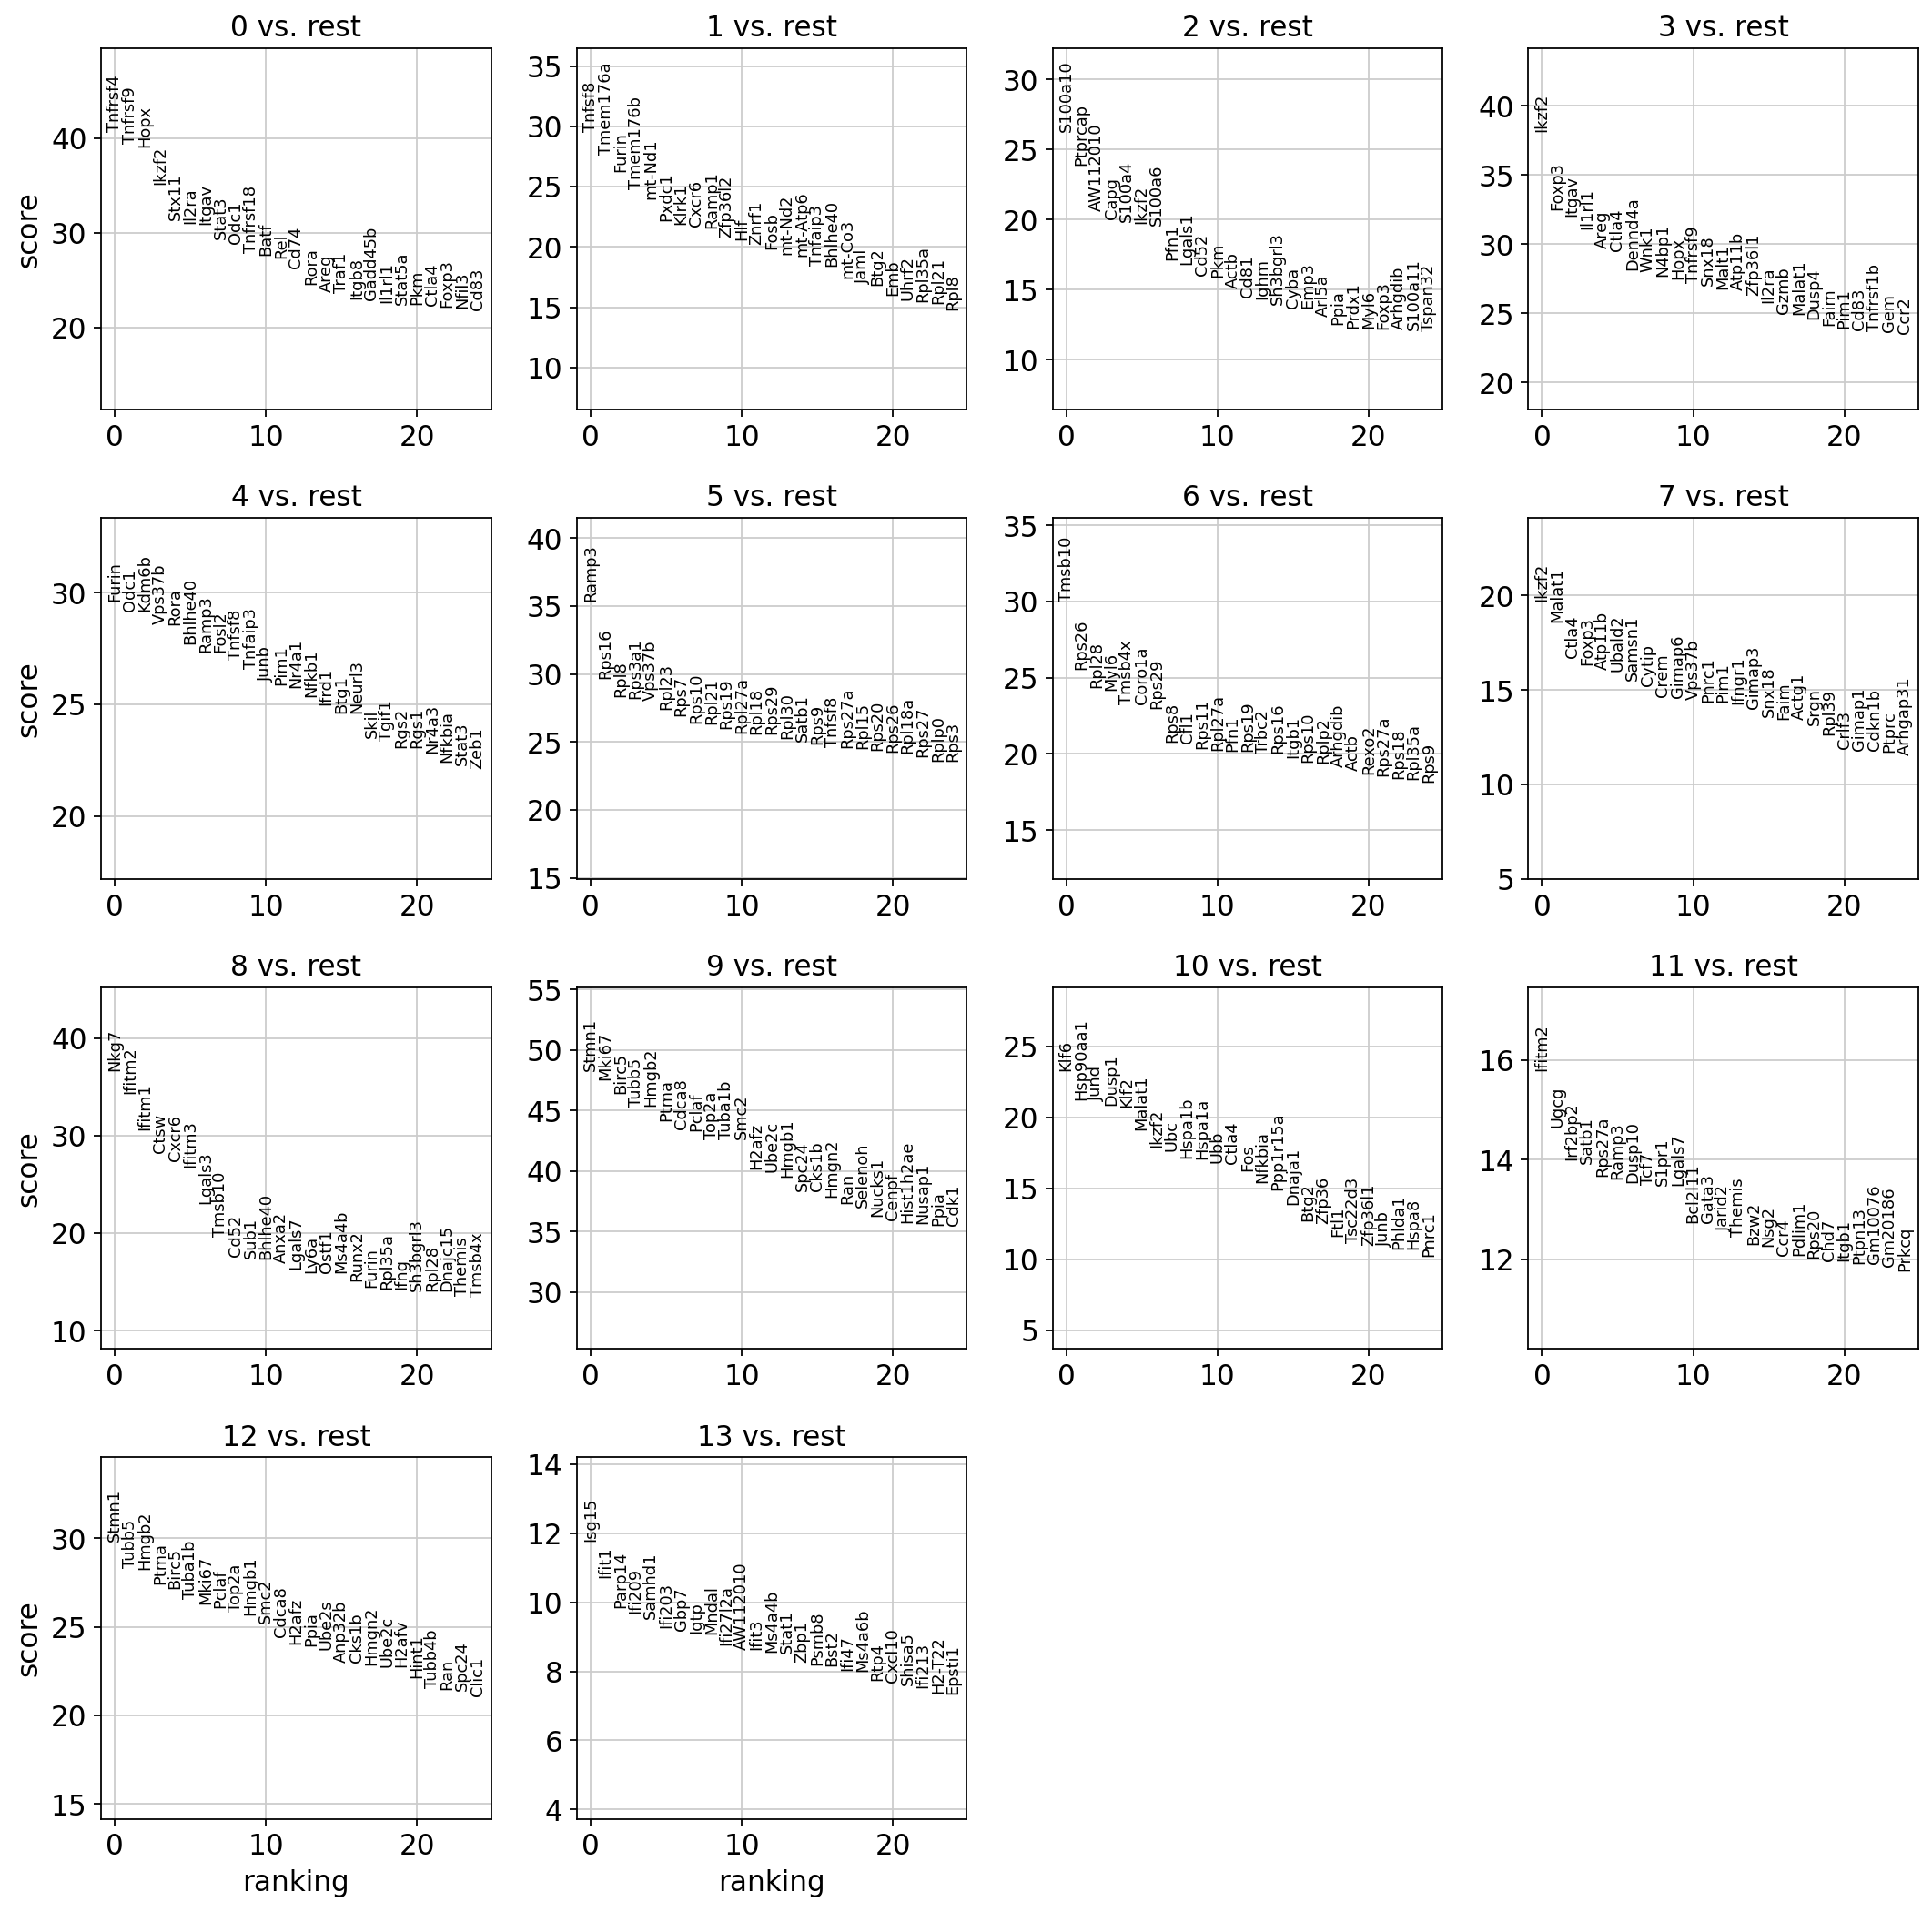

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,Tnfrsf4,Tnfsf8,S100a10,Ikzf2,Furin,Ramp3,Tmsb10,Ikzf2,Nkg7,Stmn1,Klf6,Ifitm2,Stmn1,Isg15
1,Tnfrsf9,Tmem176a,Ptprcap,Foxp3,Odc1,Rps16,Rps26,Malat1,Ifitm2,Mki67,Hsp90aa1,Ugcg,Tubb5,Ifit1
2,Hopx,Furin,AW112010,Itgav,Kdm6b,Rpl8,Rpl28,Ctla4,Ifitm1,Birc5,Jund,Irf2bp2,Hmgb2,Parp14
3,Ikzf2,Tmem176b,Capg,Il1rl1,Vps37b,Rps3a1,Myl6,Foxp3,Ctsw,Tubb5,Dusp1,Satb1,Ptma,Ifi209
4,Stx11,mt-Nd1,S100a4,Areg,Rora,Vps37b,Tmsb4x,Atp11b,Cxcr6,Hmgb2,Klf2,Rps27a,Birc5,Samhd1
5,Il2ra,Pxdc1,Ikzf2,Ctla4,Bhlhe40,Rpl23,Coro1a,Ubald2,Ifitm3,Ptma,Malat1,Ramp3,Tuba1b,Ifi203
6,Itgav,Klrk1,S100a6,Dennd4a,Ramp3,Rps7,Rps29,Samsn1,Lgals3,Cdca8,Ikzf2,Dusp10,Mki67,Gbp7
7,Stat3,Cxcr6,Pfn1,Wnk1,Fosl2,Rps10,Rps8,Cytip,Tmsb10,Pclaf,Ubc,Tcf7,Pclaf,Igtp
8,Odc1,Ramp1,Lgals1,N4bp1,Tnfsf8,Rpl21,Cfl1,Crem,Cd52,Top2a,Hspa1b,S1pr1,Top2a,Mndal
9,Tnfrsf18,Zfp36l2,Cd52,Hopx,Tnfaip3,Rps19,Rps11,Gimap6,Sub1,Tuba1b,Hspa1a,Lgals7,Hmgb1,Ifi27l2a


In [31]:
## Get DE genes for leiden
sc.tl.rank_genes_groups(filt, 'leiden_r0.9', method='wilcoxon')
sc.pl.rank_genes_groups(filt, n_genes=25, sharey=False)
pd.DataFrame(filt.uns['rank_genes_groups']['names']).head(20)

In [32]:
filt

AnnData object with n_obs × n_vars = 15295 × 17051 
    obs: 'batch', 'condition', 'geno', 'sample', 'n_genes', 'n_counts', 'log_counts', 'percent_mito', 'leiden', 'leiden_r0.9'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'sample_colors', 'geno_colors', 'condition_colors', 'leiden', 'leiden_colors', 'rank_genes_groups', 'leiden_r0.9_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [33]:
filt.write('Fig3_filteredGEX.h5ad')